# **Importing Libraries**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [1]:
#Import tensorflow and keras modules
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.applications  import efficientnet
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras_flops import get_flops
import tensorflow as tf

#Import other modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import talos
import math
import pickle
import os
%matplotlib inline

In [2]:
#Save Model Function
def save_m(file, model):
    if not os.path.exists(file):
        os.makedirs(file)

    model.save_weights(file+'/model.h5')
    model_json = model.to_json()
    with open(file + "/model.json", "w") as json_file:
        json_file.write(model_json)

#Save History Function
def save_h(file, history):
    if not os.path.exists(file):
        os.makedirs(file)

    with open(file + '/' + 'model.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)

#Load Model Function
def load_m(file):
	if not os.path.exists(file) and file != 'EnsembleModel':
		print("\n[ERROR] Model path '" + file +  "' does not exist.")
		exit()

	with open(file + "/model.json", "r") as json_file:
		model = json_file.read()
		model = model_from_json(model)
		model.load_weights(file+'/model.h5')
		return model

#Load History Function
def load_h(file):
    with open(file + '/' + 'model.history', 'rb') as file_pi:
        his = pickle.load(file_pi)
    return his

#Get data from generator function
def get_data(generator, nb_samples):  
    from tqdm.notebook import tqdm
    x = []
    y = []

    for i in tqdm(range(math.ceil(nb_samples/BATCH_SIZE))):
        x.extend(generator[i][0])
        y.extend(generator[i][1])

    x = np.array(x)
    y = np.array(y)
    return x, y

#Create generator from data function
def get_generator(x, y, preprocess_input, shuffle=True):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    datagen = datagen.flow(x, y, batch_size=BATCH_SIZE, shuffle=shuffle)
    return datagen

# **Loading Data**

In [3]:
#Define Constants
IMAGE_SIZE = (256, 256)
MODEL_INPUT = Input(shape=(256, 256, 3))
BATCH_SIZE = 4
EPOCHS = 30
LEARNING_RATE = 0.0001

#Data paths
TRAIN_DATA_PATH = 'ds/train/'
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

#Model path
DIST_STUDENT_MODEL_PATH = 'models/Distilled_Student_Models/'
NORMAL_STUDENT_MODEL_PATH = 'models/Student_Models/'
TEACHER_MODEL_PATH = 'models/Teacher_Models/'

TEACHER_NAME = 'EfficientNetB7'
STUDENT_NAME = 'KD-EfficientNetB0'

In [ ]:
#Create Generator from datapath
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(TRAIN_DATA_PATH, 
                                                    target_size=IMAGE_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    shuffle=False)

validation_generator = datagen.flow_from_directory(VAL_DATA_PATH, 
                                                        target_size=IMAGE_SIZE, 
                                                        batch_size=BATCH_SIZE, 
                                                        class_mode='categorical',
                                                        shuffle=False)

test_generator = datagen.flow_from_directory(TEST_DATA_PATH, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical',
                                                  shuffle=False)

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)
num_classes= len(train_generator.class_indices)

print('NUMBER OF TRAIN SAMPLES:', nb_train_samples)
print('NUMBER OF VALIDATION SAMPLES:',nb_validation_samples)
print('NUMBER OF TEST SAMPLES:',nb_test_samples)
print('TOTAL CLASSES:', num_classes)

Found 1990 images belonging to 199 classes.
Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.
NUMBER OF TRAIN SAMPLES: 1990
NUMBER OF VALIDATION SAMPLES: 1194
NUMBER OF TEST SAMPLES: 796
TOTAL CLASSES: 199


# **Knowledge Distillation**

**KD Class**

In [ ]:
class KDistiller(Model):
    def __init__(self, student, teacher):
        super(KDistiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha,
        temperature,
    ):
        super(KDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_preds = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_preds = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_preds)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics 
        self.compiled_metrics.update_state(y, student_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss, 'combined_loss':loss}
        )

        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_preds = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_preds)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_preds)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs, training):
        return self.student(inputs, training=training)

**Teacher Model :** EfficientNetB7 

In [ ]:
# Load the teacher
def get_teacher(directory):
    model = load_m(directory)
    return model

print("TEACHER MODEL\n\n\n")
get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME).summary()

TEACHER MODEL



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 8, 8, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 199)               509639    
Total params: 64,607,326
Trainable params: 64,296,599
Non-trainable params: 310,727
_________________________________________________________________


**Student Model :** EfficientNetB0

In [ ]:
#Create the student
def get_student():
    transfer = efficientnet.EfficientNetB0(include_top = False, weights = 'imagenet', input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    gap2D = GlobalAveragePooling2D()(transfer.layers[-1].output)
    drop = Dropout(0.5)(gap2D)
    classifier = Dense(199)(drop)
    
    model = Model(inputs = transfer.inputs, outputs = classifier)
    model.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

    return model

print("STUDENT MODEL\n\n\n")
get_student().summary()

STUDENT MODEL



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________

**Training Student With KD**

In [ ]:
#Get training data in x, y format
print("Loading Training Data")
x_train, y_train = get_data(train_generator, nb_train_samples)

print("Loading Validation Data")
x_val, y_val = get_data(validation_generator, nb_validation_samples)

print("Loading Testing Data")
x_test, y_test = get_data(test_generator, nb_test_samples)

Loading Training Data


  0%|          | 0/498 [00:00<?, ?it/s]

Loading Validation Data


  0%|          | 0/299 [00:00<?, ?it/s]

Loading Testing Data


  0%|          | 0/199 [00:00<?, ?it/s]

In [ ]:
# Distill teacher to student
p = {
    'temperature':[2, 3, 5, 10],
    'alpha':[0.1, 0.3, 0.5] 
    }

def distiller_model(x_train, y_train, x_val, y_val, params):
    #Get teacher and student model                
    teacher = get_teacher(TEACHER_MODEL_PATH  + TEACHER_NAME)
    student = get_student()

    #Create Knowledge distiller
    distiller = KDistiller(student=student, teacher=teacher)

    #Compile Knowledge distiller
    distiller.compile(
        optimizer = Adam(learning_rate=LEARNING_RATE),
        metrics=[CategoricalAccuracy()],
        student_loss_fn=CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn= KLDivergence(),
        alpha=params['alpha'],
        temperature=params['temperature'],
    )

    #Get train and val generator
    train_generator = get_generator(x_train, y_train, efficientnet.preprocess_input)
    validation_generator = get_generator(x_val, y_val, efficientnet.preprocess_input)

    #Training
    distiller_history = distiller.fit(train_generator,
                                        validation_data = validation_generator,
                                        steps_per_epoch = nb_train_samples// BATCH_SIZE,
                                        validation_steps = nb_validation_samples// BATCH_SIZE,
                                        epochs=EPOCHS
                                      )

    return distiller_history, distiller.student

scan_object = talos.Scan(x_train, y_train, experiment_name=STUDENT_NAME+'exp', x_val=x_val, y_val=y_val, model=distiller_model, params=p)


  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Epoch 1/30
497/497 [==============================] - 109s 197ms/step - categorical_accuracy: 0.0181 - student_loss: 5.2559 - distillation_loss: 2.6527 - combined_loss: 2.9130 - val_categorical_accuracy: 0.0419 - val_student_loss: 5.2316
Epoch 2/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.1118 - student_loss: 4.6536 - distillation_loss: 2.4448 - combined_loss: 2.6657 - val_categorical_accuracy: 0.2206 - val_student_loss: 4.0361
Epoch 3/30
497/497 [==============================] - 95s 191ms/step - categorical_accuracy: 0.2659 - student_loss: 3.7272 - distillation_loss: 2.1133 - combined_loss: 2.2747 - val_categorical_accuracy: 0.4430 - val_student_loss: 2.6770
Epoch 4/30
497/497 [==============================] - 95s 190ms/step - categorical_accuracy: 0.4708 - student_loss: 2.7302 - distillation_loss: 1.7388 - combined_loss: 1.8379 - val_categorical_accuracy: 0.5570 - val_student_loss: 2.0364
Epoch 5/30
497/497 [==============================]


  8%|██████▌                                                                        | 1/12 [46:11<8:28:09, 2771.79s/it]

Epoch 1/30
497/497 [==============================] - 103s 188ms/step - categorical_accuracy: 0.0166 - student_loss: 5.2102 - distillation_loss: 0.6992 - combined_loss: 1.1503 - val_categorical_accuracy: 0.0529 - val_student_loss: 5.1489
Epoch 2/30
497/497 [==============================] - 93s 187ms/step - categorical_accuracy: 0.1349 - student_loss: 4.4681 - distillation_loss: 0.6337 - combined_loss: 1.0172 - val_categorical_accuracy: 0.2861 - val_student_loss: 3.9242
Epoch 3/30
497/497 [==============================] - 93s 187ms/step - categorical_accuracy: 0.3404 - student_loss: 3.4641 - distillation_loss: 0.5498 - combined_loss: 0.8412 - val_categorical_accuracy: 0.4664 - val_student_loss: 2.9666
Epoch 4/30
497/497 [==============================] - 93s 186ms/step - categorical_accuracy: 0.5780 - student_loss: 2.5271 - distillation_loss: 0.4693 - combined_loss: 0.6750 - val_categorical_accuracy: 0.6057 - val_student_loss: 1.8646
Epoch 5/30
497/497 [==============================]


 17%|████████████▊                                                                | 2/12 [1:32:54<7:44:58, 2789.82s/it]

Epoch 1/30
497/497 [==============================] - 103s 189ms/step - categorical_accuracy: 0.0156 - student_loss: 5.2466 - distillation_loss: 0.1198 - combined_loss: 0.6324 - val_categorical_accuracy: 0.0461 - val_student_loss: 4.8659
Epoch 2/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.1299 - student_loss: 4.6320 - distillation_loss: 0.1110 - combined_loss: 0.5631 - val_categorical_accuracy: 0.2752 - val_student_loss: 4.0678
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3389 - student_loss: 3.6331 - distillation_loss: 0.0989 - combined_loss: 0.4523 - val_categorical_accuracy: 0.4144 - val_student_loss: 2.8114
Epoch 4/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.5645 - student_loss: 2.7173 - distillation_loss: 0.0895 - combined_loss: 0.3523 - val_categorical_accuracy: 0.6049 - val_student_loss: 1.4175
Epoch 5/30
497/497 [==============================]


 25%|███████████████████▎                                                         | 3/12 [2:19:46<7:00:01, 2800.13s/it]

Epoch 1/30
497/497 [==============================] - 103s 189ms/step - categorical_accuracy: 0.0196 - student_loss: 5.2391 - distillation_loss: 0.0186 - combined_loss: 0.5406 - val_categorical_accuracy: 0.0545 - val_student_loss: 4.8476
Epoch 2/30
497/497 [==============================] - 93s 187ms/step - categorical_accuracy: 0.1224 - student_loss: 4.6561 - distillation_loss: 0.0174 - combined_loss: 0.4813 - val_categorical_accuracy: 0.2643 - val_student_loss: 4.4286
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3233 - student_loss: 3.7155 - distillation_loss: 0.0162 - combined_loss: 0.3861 - val_categorical_accuracy: 0.4857 - val_student_loss: 3.1423
Epoch 4/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.5710 - student_loss: 2.7411 - distillation_loss: 0.0155 - combined_loss: 0.2881 - val_categorical_accuracy: 0.6216 - val_student_loss: 2.6377
Epoch 5/30
497/497 [==============================]


 33%|█████████████████████████▋                                                   | 4/12 [3:06:53<6:14:46, 2810.85s/it]

Epoch 1/30
497/497 [==============================] - 104s 191ms/step - categorical_accuracy: 0.0136 - student_loss: 5.2518 - distillation_loss: 2.6522 - combined_loss: 3.4321 - val_categorical_accuracy: 0.0310 - val_student_loss: 5.1901
Epoch 2/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.1244 - student_loss: 4.5912 - distillation_loss: 2.4298 - combined_loss: 3.0782 - val_categorical_accuracy: 0.1888 - val_student_loss: 3.4601
Epoch 3/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.2956 - student_loss: 3.6292 - distillation_loss: 2.0882 - combined_loss: 2.5505 - val_categorical_accuracy: 0.3792 - val_student_loss: 2.7553
Epoch 4/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.5272 - student_loss: 2.6182 - distillation_loss: 1.7149 - combined_loss: 1.9859 - val_categorical_accuracy: 0.5294 - val_student_loss: 1.5683
Epoch 5/30
497/497 [==============================]


 42%|████████████████████████████████                                             | 5/12 [3:54:08<5:28:55, 2819.42s/it]

Epoch 1/30
497/497 [==============================] - 104s 190ms/step - categorical_accuracy: 0.0166 - student_loss: 5.2370 - distillation_loss: 0.7004 - combined_loss: 2.0613 - val_categorical_accuracy: 0.0529 - val_student_loss: 4.8229
Epoch 2/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.1334 - student_loss: 4.5935 - distillation_loss: 0.6479 - combined_loss: 1.8316 - val_categorical_accuracy: 0.2752 - val_student_loss: 3.8221
Epoch 3/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.3338 - student_loss: 3.6167 - distillation_loss: 0.5682 - combined_loss: 1.4828 - val_categorical_accuracy: 0.4555 - val_student_loss: 1.6732
Epoch 4/30
497/497 [==============================] - 94s 188ms/step - categorical_accuracy: 0.5770 - student_loss: 2.6236 - distillation_loss: 0.4874 - combined_loss: 1.1283 - val_categorical_accuracy: 0.5789 - val_student_loss: 0.8949
Epoch 5/30
497/497 [==============================]


 50%|██████████████████████████████████████▌                                      | 6/12 [4:41:14<4:42:09, 2821.66s/it]

Epoch 1/30
497/497 [==============================] - 104s 192ms/step - categorical_accuracy: 0.0206 - student_loss: 5.2339 - distillation_loss: 0.1199 - combined_loss: 1.6541 - val_categorical_accuracy: 0.0378 - val_student_loss: 5.2632
Epoch 2/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.1254 - student_loss: 4.6421 - distillation_loss: 0.1122 - combined_loss: 1.4712 - val_categorical_accuracy: 0.3020 - val_student_loss: 3.8263
Epoch 3/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.3530 - student_loss: 3.6302 - distillation_loss: 0.1003 - combined_loss: 1.1593 - val_categorical_accuracy: 0.5260 - val_student_loss: 2.5287
Epoch 4/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.6022 - student_loss: 2.6124 - distillation_loss: 0.0900 - combined_loss: 0.8467 - val_categorical_accuracy: 0.6435 - val_student_loss: 2.6449
Epoch 5/30
497/497 [==============================]


 58%|████████████████████████████████████████████▉                                | 7/12 [5:28:15<3:55:07, 2821.44s/it]

Epoch 1/30
497/497 [==============================] - 103s 190ms/step - categorical_accuracy: 0.0186 - student_loss: 5.2705 - distillation_loss: 0.0186 - combined_loss: 1.5942 - val_categorical_accuracy: 0.0436 - val_student_loss: 5.1647
Epoch 2/30
497/497 [==============================] - 94s 188ms/step - categorical_accuracy: 0.1083 - student_loss: 4.6977 - distillation_loss: 0.0175 - combined_loss: 1.4216 - val_categorical_accuracy: 0.1862 - val_student_loss: 3.6268
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3137 - student_loss: 3.7775 - distillation_loss: 0.0163 - combined_loss: 1.1447 - val_categorical_accuracy: 0.4010 - val_student_loss: 2.7896
Epoch 4/30
497/497 [==============================] - 94s 188ms/step - categorical_accuracy: 0.5448 - student_loss: 2.8102 - distillation_loss: 0.0157 - combined_loss: 0.8541 - val_categorical_accuracy: 0.5856 - val_student_loss: 2.3668
Epoch 5/30
497/497 [==============================]


 67%|███████████████████████████████████████████████████▎                         | 8/12 [6:15:14<3:08:02, 2820.67s/it]

Epoch 1/30
497/497 [==============================] - 102s 189ms/step - categorical_accuracy: 0.0156 - student_loss: 5.2514 - distillation_loss: 2.6478 - combined_loss: 3.9496 - val_categorical_accuracy: 0.0520 - val_student_loss: 5.0797
Epoch 2/30
497/497 [==============================] - 93s 187ms/step - categorical_accuracy: 0.1148 - student_loss: 4.6319 - distillation_loss: 2.4416 - combined_loss: 3.5367 - val_categorical_accuracy: 0.1888 - val_student_loss: 4.0866
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3066 - student_loss: 3.6697 - distillation_loss: 2.1083 - combined_loss: 2.8890 - val_categorical_accuracy: 0.4153 - val_student_loss: 3.4946
Epoch 4/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.5332 - student_loss: 2.7059 - distillation_loss: 1.7640 - combined_loss: 2.2350 - val_categorical_accuracy: 0.5713 - val_student_loss: 1.8026
Epoch 5/30
497/497 [==============================]


 75%|█████████████████████████████████████████████████████████▊                   | 9/12 [7:02:06<2:20:53, 2817.90s/it]

Epoch 1/30
497/497 [==============================] - 102s 189ms/step - categorical_accuracy: 0.0131 - student_loss: 5.2316 - distillation_loss: 0.7010 - combined_loss: 2.9663 - val_categorical_accuracy: 0.0604 - val_student_loss: 5.0737
Epoch 2/30
497/497 [==============================] - 93s 187ms/step - categorical_accuracy: 0.1254 - student_loss: 4.5839 - distillation_loss: 0.6463 - combined_loss: 2.6151 - val_categorical_accuracy: 0.2819 - val_student_loss: 4.6087
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3625 - student_loss: 3.6077 - distillation_loss: 0.5662 - combined_loss: 2.0870 - val_categorical_accuracy: 0.4958 - val_student_loss: 2.6921
Epoch 4/30
497/497 [==============================] - 93s 187ms/step - categorical_accuracy: 0.5851 - student_loss: 2.6381 - distillation_loss: 0.4892 - combined_loss: 1.5636 - val_categorical_accuracy: 0.5982 - val_student_loss: 2.8998
Epoch 5/30
497/497 [==============================]


 83%|███████████████████████████████████████████████████████████████▎            | 10/12 [7:48:57<1:33:51, 2815.68s/it]

Epoch 1/30
497/497 [==============================] - 102s 189ms/step - categorical_accuracy: 0.0126 - student_loss: 5.2450 - distillation_loss: 0.1200 - combined_loss: 2.6825 - val_categorical_accuracy: 0.0419 - val_student_loss: 4.8765
Epoch 2/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.1229 - student_loss: 4.6446 - distillation_loss: 0.1121 - combined_loss: 2.3783 - val_categorical_accuracy: 0.2022 - val_student_loss: 4.3314
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3343 - student_loss: 3.6539 - distillation_loss: 0.1008 - combined_loss: 1.8774 - val_categorical_accuracy: 0.4597 - val_student_loss: 2.7627
Epoch 4/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.5639 - student_loss: 2.6604 - distillation_loss: 0.0913 - combined_loss: 1.3758 - val_categorical_accuracy: 0.6015 - val_student_loss: 2.1482
Epoch 5/30
497/497 [==============================]


 92%|███████████████████████████████████████████████████████████████████████▌      | 11/12 [8:35:54<46:56, 2816.22s/it]

Epoch 1/30
497/497 [==============================] - 103s 189ms/step - categorical_accuracy: 0.0196 - student_loss: 5.2350 - distillation_loss: 0.0185 - combined_loss: 2.6268 - val_categorical_accuracy: 0.0554 - val_student_loss: 4.8457
Epoch 2/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.1138 - student_loss: 4.6267 - distillation_loss: 0.0174 - combined_loss: 2.3220 - val_categorical_accuracy: 0.2643 - val_student_loss: 4.5295
Epoch 3/30
497/497 [==============================] - 93s 188ms/step - categorical_accuracy: 0.3212 - student_loss: 3.6830 - distillation_loss: 0.0161 - combined_loss: 1.8496 - val_categorical_accuracy: 0.4371 - val_student_loss: 2.4049
Epoch 4/30
497/497 [==============================] - 94s 189ms/step - categorical_accuracy: 0.5720 - student_loss: 2.6596 - distillation_loss: 0.0155 - combined_loss: 1.3375 - val_categorical_accuracy: 0.6099 - val_student_loss: 1.2506
Epoch 5/30
497/497 [==============================]


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [9:22:50<00:00, 2814.23s/it]


In [ ]:
r = talos.Reporting(STUDENT_NAME + 'exp/results.csv')
model_index = r.data.loc[r.data['val_categorical_accuracy'] == np.max(r.data['val_categorical_accuracy'])].index[0]
val_acc = np.max(r.data['val_categorical_accuracy'])

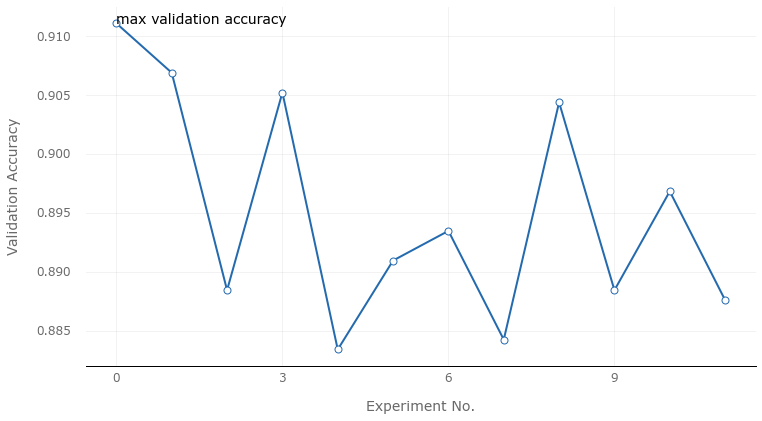

In [ ]:
#See the line plot -> model_index vs validation accuracy 
r.plot_line('val_categorical_accuracy')
plt.xlabel('Experiment No.')
plt.ylabel('Validation Accuracy')
plt.annotate( 'max validation accuracy', (model_index, val_acc))
plt.show()

In [ ]:
#See the result of best student for different temperature and alpha
r.data.iloc[[model_index]]

,round_epochs,categorical_accuracy,student_loss,distillation_loss,combined_loss,val_categorical_accuracy,val_student_loss,alpha,temperature
0,30,0.999496,0.031117,0.085322,0.079901,0.911074,0.09988,0.1,2


In [ ]:
#Create best Student
best_student = model_from_json(scan_object.saved_models[model_index])
weights = scan_object.saved_weights[model_index]
best_student.set_weights(weights)

best_student.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

#Load teacher
temp_teacher = get_teacher(TEACHER_MODEL_PATH + TEACHER_NAME)
temp_teacher.compile(
          optimizer = Adam(learning_rate=LEARNING_RATE),
          loss = CategoricalCrossentropy(from_logits=True),
          metrics = [CategoricalAccuracy()]
    )

print("Evaluating Student on test dataset\n")
test_generator = get_generator(x_test, y_test, efficientnet.preprocess_input, shuffle=False)
s_acc = best_student.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

print("\nEvaluating Teacher on test dataset\n")
test_generator = get_generator(x_test, y_test, efficientnet.preprocess_input, shuffle=False)
t_acc = temp_teacher.evaluate(test_generator, steps=np.ceil(nb_test_samples/BATCH_SIZE))

Evaluating Student on test dataset



  0%|                                                                                         | 0/12 [9:36:00<?, ?it/s]


199/199 [==============================] - 21s 20ms/step - loss: 0.5485 - categorical_accuracy: 0.8999

Evaluating Teacher on test dataset

199/199 [==============================] - 41s 85ms/step - loss: 0.2800 - categorical_accuracy: 0.9386


**Saving Model**

In [ ]:
print("MODEL AND HISTORY SAVED")
#save models
save_m(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, best_student)

#save history
distiller_history = scan_object.round_history[model_index]
save_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME, distiller_history)

MODEL AND HISTORY SAVED


**Final Results**

In [ ]:
student_acc = "{0:.3f} ".format(s_acc[1]*100)
student_size = "{0:.2f} M".format(best_student.count_params()/10**6)
student_flops = "{0:.2f} G".format(get_flops(Model(best_student.input, best_student.output), batch_size=1)/ 10 ** 9)

teacher_acc = "{0:.3f} ".format(t_acc[1]*100)
teacher_size = "{0:.2f} M".format(temp_teacher.count_params()/10**6)
teacher_flops = "{0:.2f} G".format(get_flops(Model(temp_teacher.input, temp_teacher.output), batch_size=1)/ 10 ** 9)

results = {STUDENT_NAME:{'Test Accuracy(%)':student_acc,
                         'Parameters':student_size,
                         'FLOPs':student_flops},
           TEACHER_NAME:{'Test Accuracy(%)':teacher_acc,
                         'Parameters':teacher_size,
                         'FLOPs':teacher_flops}}

results = pd.DataFrame(results)
results

,KD-EfficientNetB0,EfficientNetB7
Test Accuracy(%),90.084,92.932
Parameters,4.30 M,64.61 M
FLOPs,1.04 G,13.69 G


# **Training Visualization**

In [6]:
#VISUAL CUSTOMIZER
distiller_history = load_h(DIST_STUDENT_MODEL_PATH + STUDENT_NAME)

marker_t = '^'
marker_v = '+'
market_t_loss = 'v'
market_v_loss = 'x'
markersize = 5
fillstyle_t = 'none'
fillstyle_v = 'none'

color_t = 'blue'
color_v = 'orange'

labelsize = 10
fontsize = 7

color_t_loss = 'green'
color_v_loss = 'red'

border_pad = 0.5
legend_font_size = 9

ls_t = '-' 
ls_v = '--'
lw_t = '1.5'
lw_v = '1.5'

print("You may change the values if needed for the ease of your evaluation")

You may change the values if needed for the ease of your evaluation


**Accuracy Curve**

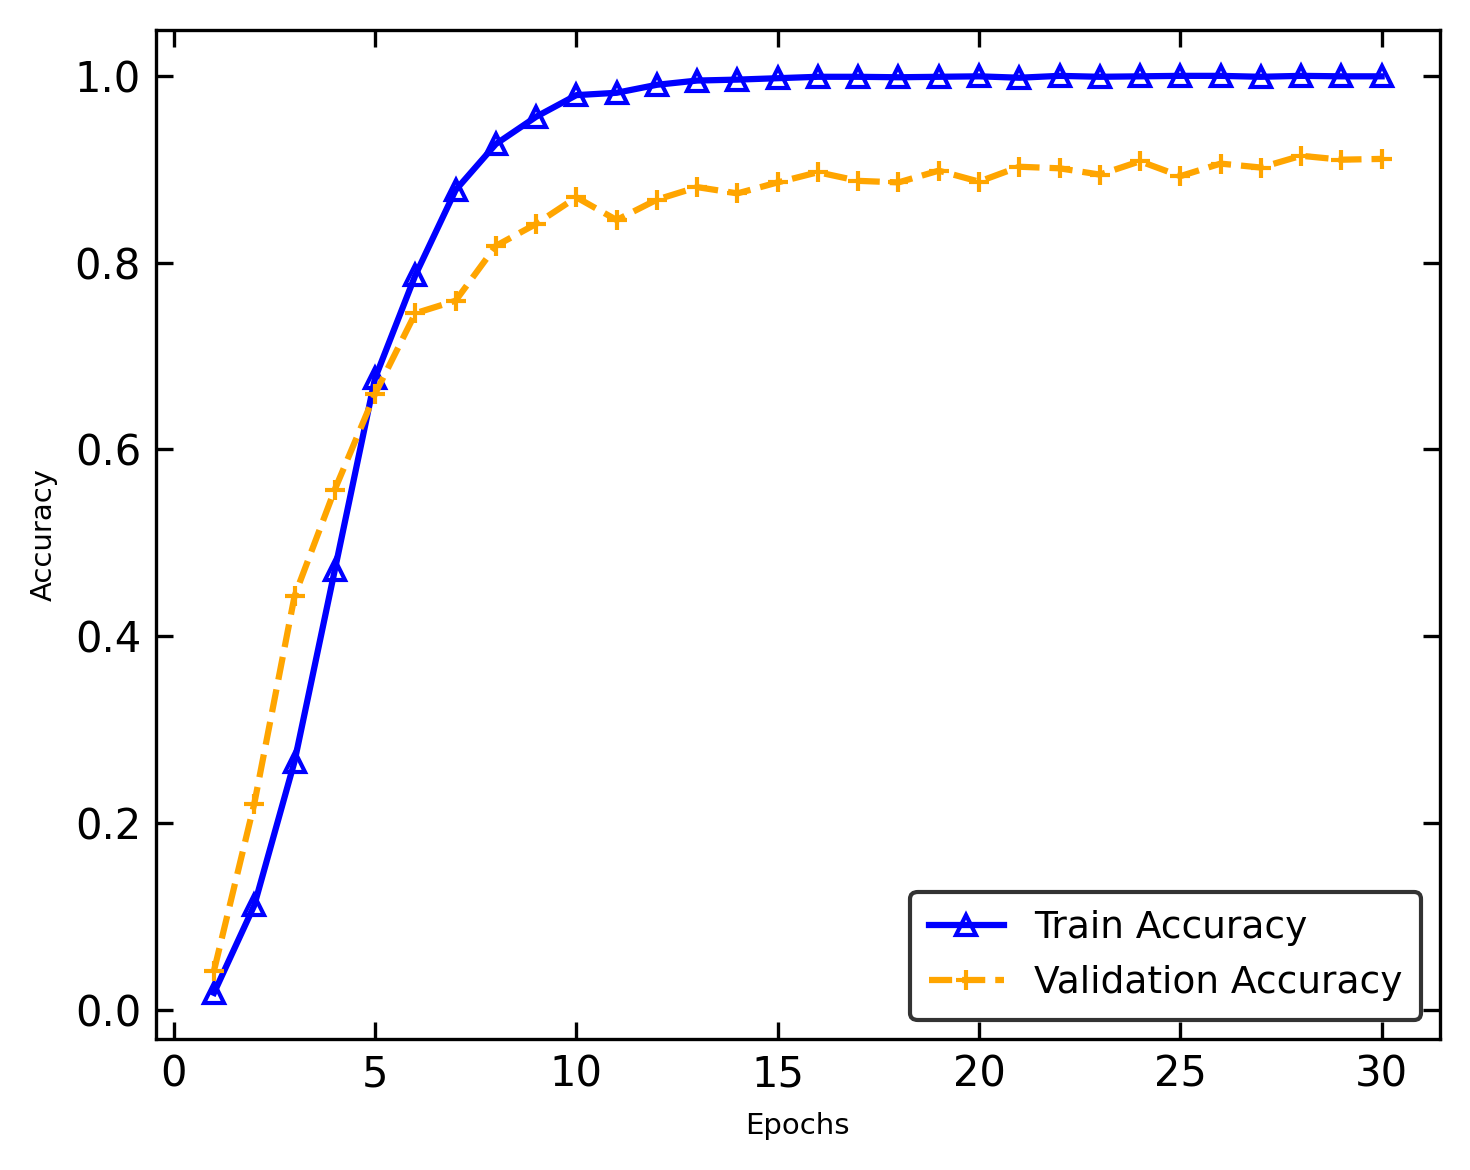

In [8]:
#PRINTS THE ACCURACY GROWTH
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300, edgecolor='black', facecolor='white', linewidth=0)
plt.tight_layout()

plt.gcf().subplots_adjust(bottom=0.15)

plt.rc('xtick',labelsize=labelsize, direction="in") 
plt.rc('ytick', labelsize=labelsize, direction="in") 
plt.tick_params(length=4, right=True, top=True)

plt.plot(np.arange(1, N+1), distiller_history["categorical_accuracy"], color=color_t,lw=lw_t, marker=marker_t, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Accuracy")
plt.plot(np.arange(1, N+1), distiller_history["val_categorical_accuracy"], color=color_v ,lw=lw_v, marker=marker_v, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v,  label="Validation Accuracy")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Accuracy", fontsize=fontsize, color='black')
plt.legend(loc="lower right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()

**Loss Curve**

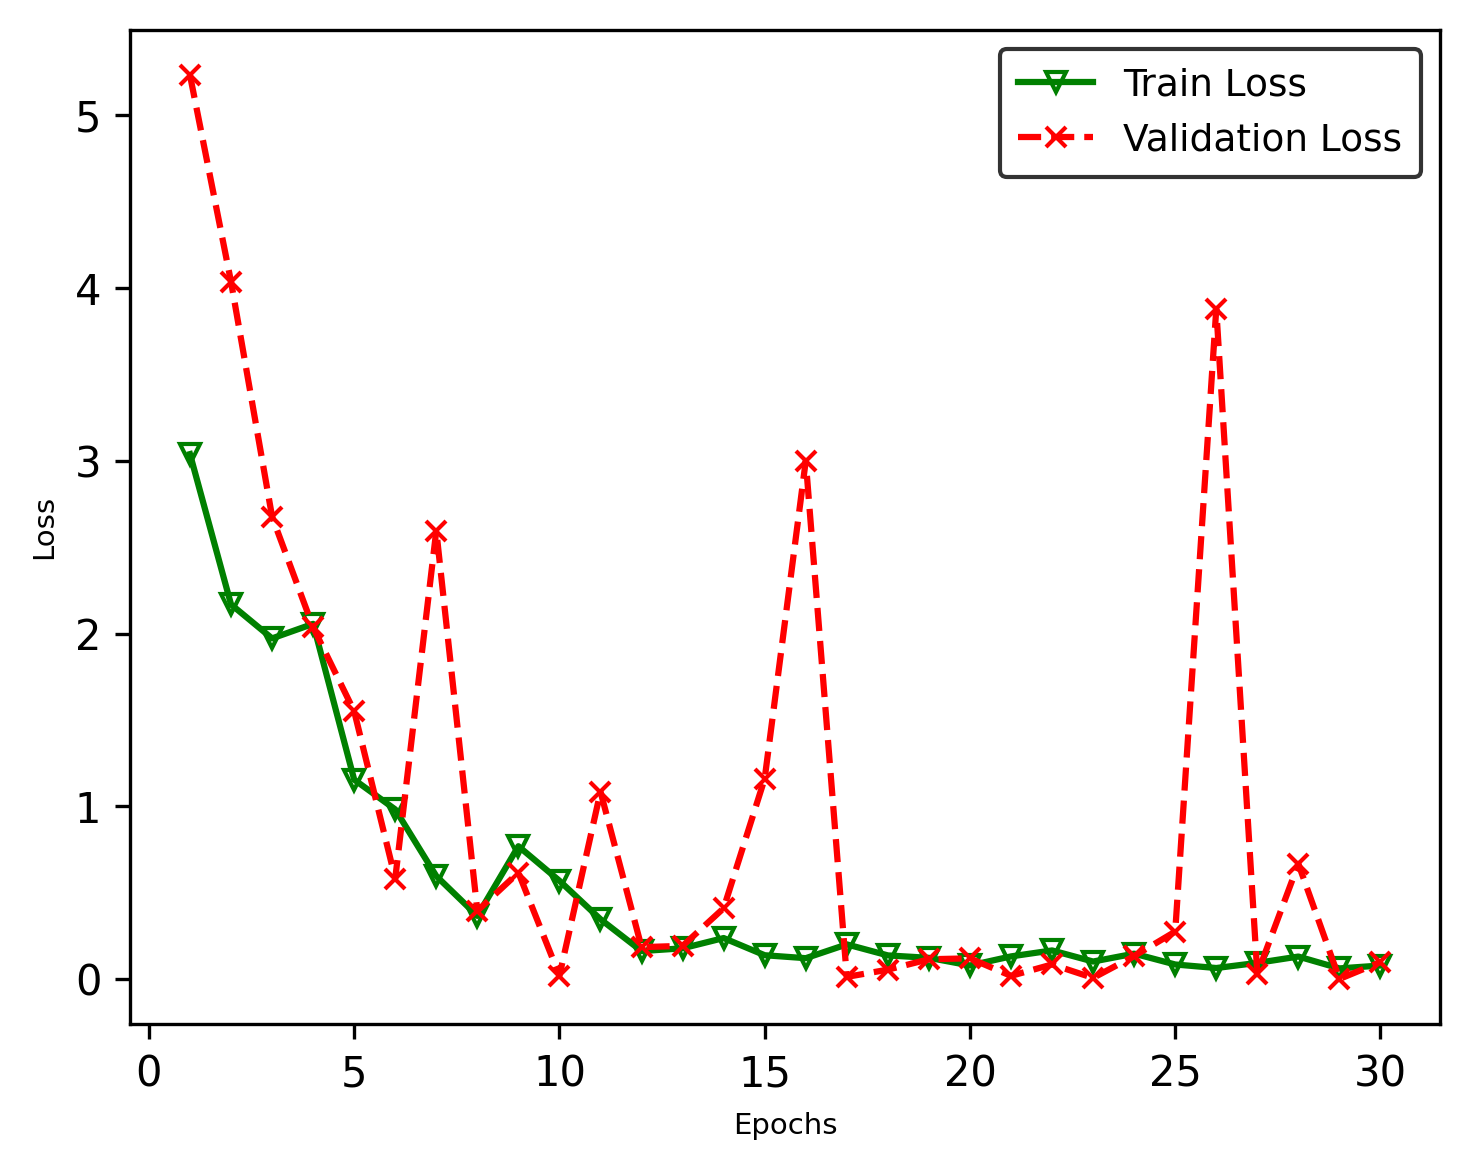

In [9]:
#PRINTS THE DECREASE OF LOSS
N = EPOCHS
plt.style.use("default")
plt.figure(figsize=(5,4), dpi=300)
plt.plot(np.arange(1, N+1), distiller_history["combined_loss"], color=color_t_loss,lw=lw_t, marker=market_t_loss, markersize=markersize, fillstyle=fillstyle_t, ls=ls_t, label="Train Loss")
plt.plot(np.arange(1, N+1), distiller_history["val_student_loss"], color=color_v_loss,lw=lw_v, marker=market_v_loss, markersize= markersize, fillstyle=fillstyle_v, ls=ls_v, label="Validation Loss")

plt.xlabel("Epochs", fontsize=fontsize, color='black')
plt.ylabel("Loss", fontsize=fontsize, color='black')
plt.legend(loc="upper right", fontsize=legend_font_size, edgecolor='black', borderpad=border_pad)
plt.tight_layout()